In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# import tensorflow_docs.plots
# import tensorflow_docs.modeling
# import tensorflow_docs as tfdocs

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Import & Preparation

In [2]:
df = pd.read_csv('data.csv')
df = df.drop(['raw', 'meditation'], axis=1)
df = df[(df.attention > 0) & (df.attention < 100)]
df.attention = df.attention / 100

df

,attention,delta,theta,low-alpha,high-alpha,low-beta,high-beta,low-gamma,mid-gamma
0,0.37,1725640,200063,53250,102958,14896,15956,9146,564479
1,0.27,2201329,47193,30590,15477,10829,3309,1812,37220
2,0.21,980945,108452,3340,6210,4686,4613,2381,158162
3,0.27,574299,56120,7371,15829,6316,7574,1531,135804
4,0.37,527756,30863,7771,3165,8692,3605,2607,174718
...,...,...,...,...,...,...,...,...,...
2010,0.53,791091,179232,49861,12184,35175,11302,4067,3863
2011,0.57,470493,188573,33894,43186,34484,32196,12978,6002
2012,0.63,474347,37641,3887,27694,17348,8264,4083,1469
2013,0.53,411366,26293,13879,12054,5604,3458,1542,951


In [3]:
X = np.array(df.drop('attention', axis=1))
y = np.array(df[['attention']])

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1610, 8), (403, 8), (1610, 1), (403, 1))

## Model

In [9]:
def feedforward_nnet():
    clear_session()
    model = Sequential()
    model.add(Dense(16, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1))
    return model

model = feedforward_nnet()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5

In [10]:
model.compile(optimizer=Adam(1e-4), loss='mae', metrics=['mae', 'mse'])
es = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0)
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=16, callbacks=[es, reduce_lr], verbose=2)

0264 - lr: 1.0000e-04
Epoch 58/200
81/81 - 0s - loss: 0.1230 - mae: 0.1230 - mse: 0.0243 - val_loss: 0.1272 - val_mae: 0.1272 - val_mse: 0.0265 - lr: 1.0000e-04
Epoch 59/200
81/81 - 0s - loss: 0.1226 - mae: 0.1226 - mse: 0.0243 - val_loss: 0.1273 - val_mae: 0.1273 - val_mse: 0.0263 - lr: 1.0000e-04
Epoch 60/200
81/81 - 0s - loss: 0.1225 - mae: 0.1225 - mse: 0.0241 - val_loss: 0.1266 - val_mae: 0.1266 - val_mse: 0.0263 - lr: 1.0000e-04
Epoch 61/200
81/81 - 0s - loss: 0.1222 - mae: 0.1222 - mse: 0.0240 - val_loss: 0.1263 - val_mae: 0.1263 - val_mse: 0.0263 - lr: 1.0000e-04
Epoch 62/200
81/81 - 0s - loss: 0.1219 - mae: 0.1219 - mse: 0.0239 - val_loss: 0.1261 - val_mae: 0.1261 - val_mse: 0.0262 - lr: 1.0000e-04
Epoch 63/200
81/81 - 0s - loss: 0.1217 - mae: 0.1217 - mse: 0.0238 - val_loss: 0.1260 - val_mae: 0.1260 - val_mse: 0.0262 - lr: 1.0000e-04
Epoch 64/200
81/81 - 0s - loss: 0.1213 - mae: 0.1213 - mse: 0.0236 - val_loss: 0.1257 - val_mae: 0.1257 - val_mse: 0.0262 - lr: 1.0000e-04
Epoch

In [13]:
y_pred = model.predict(X_test)
mean_absolute_error(y_pred, y_test)

0.11836418305008346

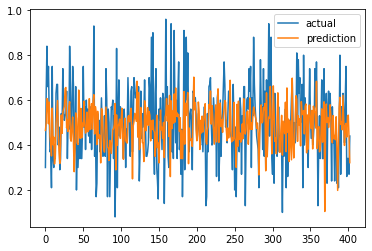

In [14]:
actual = [i[0] for i in y_test]
prediction = [i[0] for i in y_pred]

pd.DataFrame({'actual': actual, 'prediction': prediction}).plot()